In [1]:
#Step 1:
!git clone https://github.com/niaz1971/MALARIAL_CELL_CLASSIFICATION_USING_CNN.git

Cloning into 'MALARIAL_CELL_CLASSIFICATION_USING_CNN'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (309/309), done.
remote: Compressing objects: 100% (305/305), done.
remote: Total 309 (delta 16), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (309/309), 3.60 MiB | 10.77 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [2]:
!ls

MALARIAL_CELL_CLASSIFICATION_USING_CNN	sample_data


In [3]:
cd MALARIAL_CELL_CLASSIFICATION_USING_CNN/

/content/MALARIAL_CELL_CLASSIFICATION_USING_CNN


In [4]:
!ls

 kaggle.json
'Malaria Cell Classification [EfficentNet]1.ipynb'
 MalariaClassificationwithKerasFromScratch.ipynb
 VGG19_MALARIAL_CELL_CLASSIFICATION.ipynb


In [5]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fb09ee3d64ec139ca6e658d54588e9a852e4f905fc4bae0e8f2d061b24171f72
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [6]:
# Step 2: Install Kaggle API and set up .kaggle directory
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Step 3: Download and unzip the malaria cell images dataset
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip -q cell-images-for-detecting-malaria.zip

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 97% 653M/675M [00:03<00:00, 179MB/s]
100% 675M/675M [00:05<00:00, 141MB/s]


In [8]:
# Step 4: Imports
import os, random, shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import skimage.io, skimage.transform
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Set random seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
# Step 5: Prepare directories for train/valid/test splits
original_dataset = 'cell_images'
parasitized_dir = os.path.join(original_dataset, 'Parasitized')
uninfected_dir = os.path.join(original_dataset, 'Uninfected')

base_dir = 'malaria_data'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

for d in [train_dir, valid_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

classes = ['Parasitized', 'Uninfected']
for split_dir in [train_dir, valid_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

In [10]:
# Step 6: Function to split images into train/valid/test sets
def split_data(source_dir, train_dir, valid_dir, test_dir, train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1):
    files = os.listdir(source_dir)
    random.shuffle(files)
    total = len(files)
    train_end = int(total * train_ratio)
    valid_end = train_end + int(total * valid_ratio)

    train_files = files[:train_end]
    valid_files = files[train_end:valid_end]
    test_files = files[valid_end:]

    for fname in train_files:
        shutil.copy(os.path.join(source_dir, fname), os.path.join(train_dir, fname))
    for fname in valid_files:
        shutil.copy(os.path.join(source_dir, fname), os.path.join(valid_dir, fname))
    for fname in test_files:
        shutil.copy(os.path.join(source_dir, fname), os.path.join(test_dir, fname))

# Split data folders
split_data(parasitized_dir,
           os.path.join(train_dir, 'Parasitized'),
           os.path.join(valid_dir, 'Parasitized'),
           os.path.join(test_dir, 'Parasitized'))

split_data(uninfected_dir,
           os.path.join(train_dir, 'Uninfected'),
           os.path.join(valid_dir, 'Uninfected'),
           os.path.join(test_dir, 'Uninfected'))

In [11]:
# Step 7: Define ImageDataGenerators with augmentation for train and only rescale for valid/test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    shear_range=0.2,
    width_shift_range=0.4,
    height_shift_range=0.4,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

class_labels = train_generator.class_indices
class_names = {v: k for k, v in class_labels.items()}
print("Class labels:", class_labels)

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Class labels: {'Parasitized': 0, 'Uninfected': 1}


In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Step 8: Build model - use VGG16 with frozen base layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier layers
x = Flatten()(base_model.output)
x = Dense(4608, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1152, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1152)           │     5,309,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         2,306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,779,906 (220.41 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
# Step 9: Compile model
optimizer = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [14]:
# Step 10: Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, verbose=1),
    ModelCheckpoint('best_malaria_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=0.0001)
]

In [15]:
# Step 11: Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=10,
    validation_data=valid_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5234 - loss: 0.7109
Epoch 1: val_loss improved from inf to 0.60240, saving model to best_malaria_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 402ms/step - accuracy: 0.5240 - loss: 0.7105 - val_accuracy: 0.7852 - val_loss: 0.6024 - learning_rate: 1.0000e-04
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6198 - loss: 0.6435
Epoch 2: val_loss improved from 0.60240 to 0.53464, saving model to best_malaria_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 328ms/step - accuracy: 0.6204 - loss: 0.6431 - val_accuracy: 0.8052 - val_loss: 0.5346 - learning_rate: 1.0000e-04
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7029 - loss: 0.5925
Epoch 3: val_loss improved from 0.53464 to 0.49316, saving model to best_malaria_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 326ms/step - accuracy: 0.7027 - loss: 0.5926 - val_accuracy: 0.8135 - val_loss: 0.4932 - learning_rate: 1.0000e-04
Epoch 4/10
50/50 ━━━━━━━━━━━━

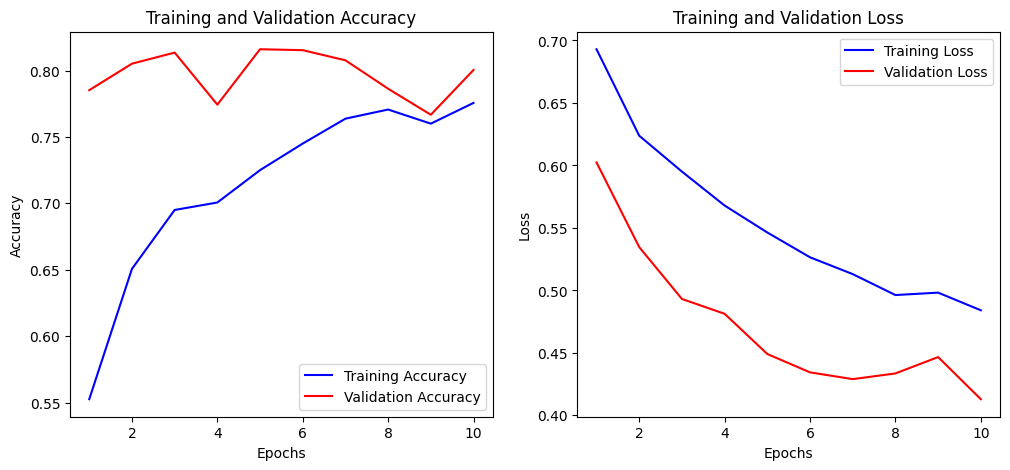

In [16]:
# Step 12: Plot training/validation accuracy and loss
def plot_training_curves(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_curves(history)

In [17]:
# Step 13: Load the best saved model
model = tf.keras.models.load_model('best_malaria_model.keras')

In [18]:
# Step 14: Evaluate on validation and test sets
val_loss, val_acc = model.evaluate(valid_generator)
test_loss, test_acc = model.evaluate(test_generator)
print(f'Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')

87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.7941 - loss: 0.4300
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.6976 - loss: 0.5396
Validation Accuracy: 0.8004, Validation Loss: 0.4129
Test Accuracy: 0.8033, Test Loss: 0.4111


In [19]:
# Step 15: Predictions and classification report on test set
nb_samples = len(test_generator.filenames)
preds = model.predict(test_generator, steps=nb_samples, verbose=1)
pred_labels = np.argmax(preds, axis=1)

print(classification_report(test_generator.classes, pred_labels,
                            target_names=[class_names[i] for i in range(2)]))

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step
              precision    recall  f1-score   support

 Parasitized       0.93      0.66      0.77      1378
  Uninfected       0.73      0.95      0.83      1378

    accuracy                           0.80      2756
   macro avg       0.83      0.80      0.80      2756
weighted avg       0.83      0.80      0.80      2756



Overall Test Accuracy: 0.8033


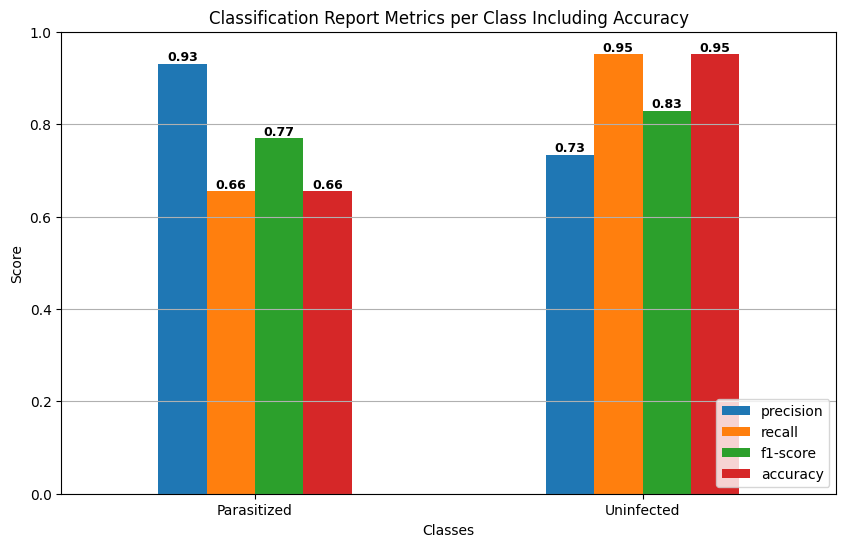


Overall Accuracy: 0.8033


In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Compute overall accuracy
accuracy = accuracy_score(test_generator.classes, pred_labels)
print(f'Overall Test Accuracy: {accuracy:.4f}')

# Generate classification report as dictionary
report_dict = classification_report(test_generator.classes, pred_labels, target_names=[class_names[i] for i in range(2)], output_dict=True)

# Convert to DataFrame for plotting
report_df = pd.DataFrame(report_dict).transpose()

# Filter classes only (exclude avg rows and support column)
report_classes = report_df.iloc[:-3, :-1]

# Compute per-class accuracy from confusion matrix
cm = confusion_matrix(test_generator.classes, pred_labels)
class_accuracies = cm.diagonal() / cm.sum(axis=1)
class_names_list = [class_names[i] for i in range(len(class_accuracies))]

# Add accuracy as new column
report_classes['accuracy'] = class_accuracies

# Plot grouped bar chart for precision, recall, f1-score, accuracy
ax = report_classes[['precision', 'recall', 'f1-score', 'accuracy']].plot(kind='bar', figsize=(10, 6))
plt.title('Classification Report Metrics per Class Including Accuracy')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.xticks(rotation=0)

# Annotate bars with values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

# Print overall accuracy
print(f"\nOverall Accuracy: {accuracy:.4f}")


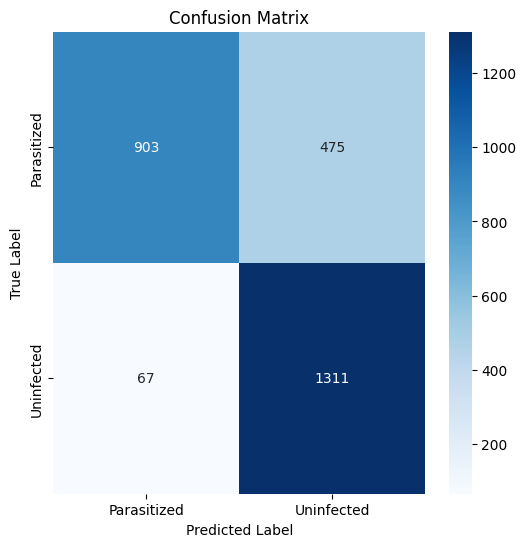

In [21]:
# Step 16: Confusion matrix plot
cm = confusion_matrix(test_generator.classes, pred_labels)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

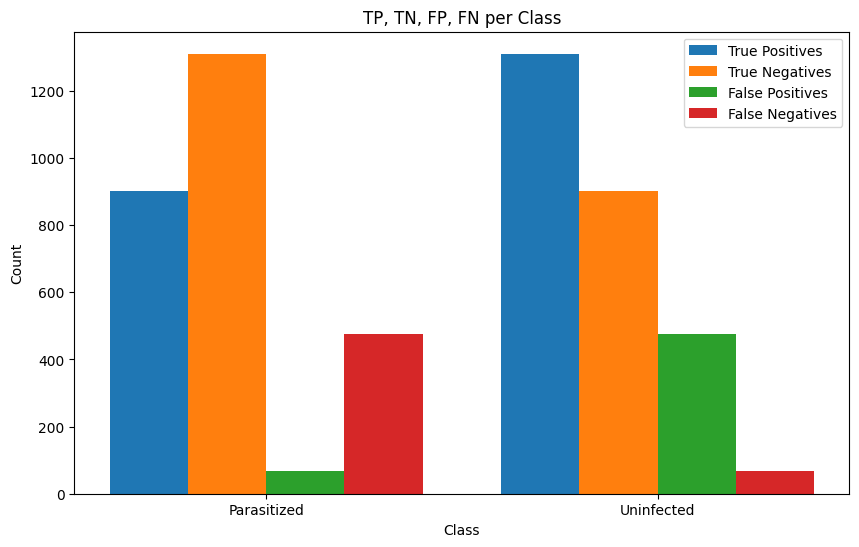

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Assume cm is confusion matrix computed from test labels and predicted labels
cm = confusion_matrix(test_generator.classes, pred_labels)

# True Positives (TP) are diagonal elements
TP = np.diag(cm)

# False Positives (FP) are column-wise sum minus TP
FP = cm.sum(axis=0) - TP

# False Negatives (FN) are row-wise sum minus TP
FN = cm.sum(axis=1) - TP

# True Negatives (TN) are sum of all elements except row and column of class
TN = []
for i in range(len(cm)):
    temp = np.delete(cm, i, axis=0)  # Remove ith row
    temp = np.delete(temp, i, axis=1)  # Remove ith column
    TN.append(temp.sum())

class_labels = list(class_names.values())

x = np.arange(len(class_labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5*width, TP, width, label='True Positives')
rects2 = ax.bar(x - 0.5*width, TN, width, label='True Negatives')
rects3 = ax.bar(x + 0.5*width, FP, width, label='False Positives')
rects4 = ax.bar(x + 1.5*width, FN, width, label='False Negatives')

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('TP, TN, FP, FN per Class')
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.legend()

plt.show()


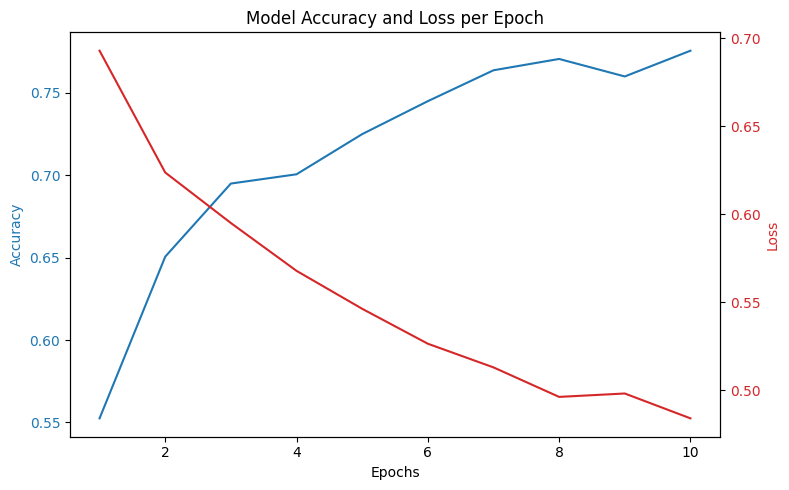

In [23]:
import matplotlib.pyplot as plt

# Sample data: replace with your training history
epochs = range(1, len(history.history['accuracy']) + 1)
accuracy = history.history['accuracy']
loss = history.history['loss']

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot accuracy on left y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(epochs, accuracy, label='Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for loss
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(epochs, loss, label='Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Model Accuracy and Loss per Epoch')
fig.tight_layout()
plt.show()


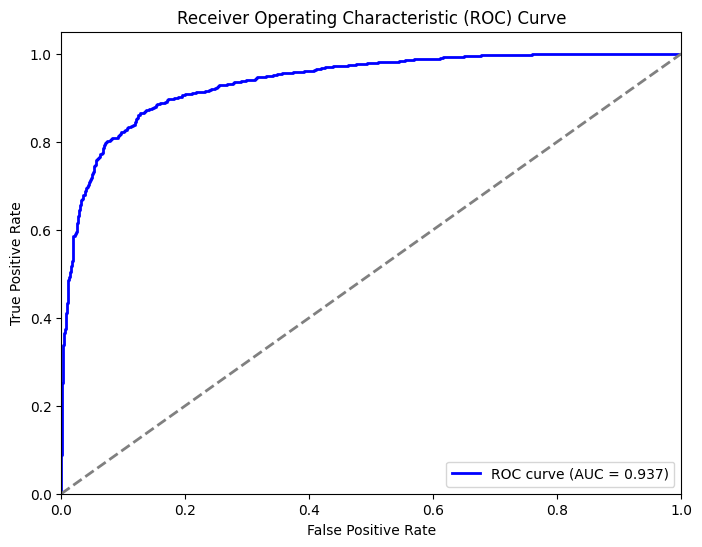

In [24]:
# Step 17: ROC Curve calculation and plotting
fpr, tpr, thresholds = roc_curve(test_generator.classes, preds[:,1])  # Use probability of positive class
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


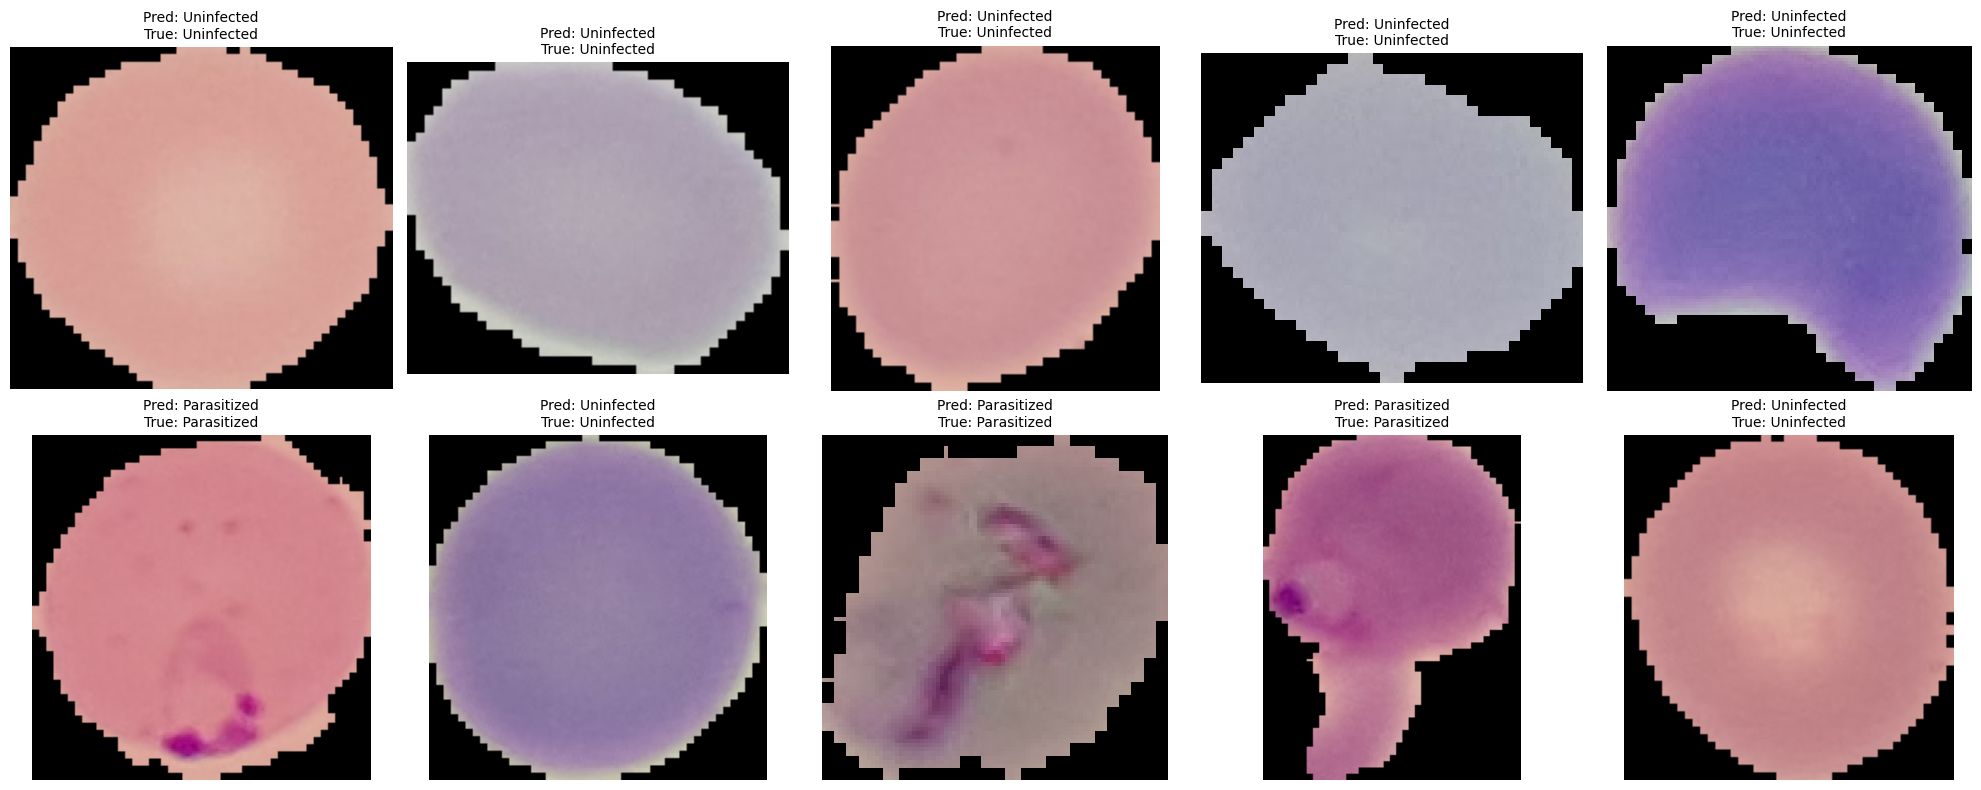

In [25]:
# Step 18: Visualize random test images with predictions
import matplotlib.image as mpimg

sample_files = random.sample(test_generator.filenames, 10)
plt.figure(figsize=(20,8))

for i, fname in enumerate(sample_files):
    plt.subplot(2, 5, i+1)
    img_path = os.path.join(test_dir, fname)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')

    img_obj = load_img(img_path, target_size=(128,128))
    img_arr = img_to_array(img_obj) / 255.0
    img_exp = np.expand_dims(img_arr, axis=0)

    pred = model.predict(img_exp)
    pred_label = class_names[np.argmax(pred)]
    true_label = os.path.basename(os.path.dirname(img_path))

    plt.title(f'Pred: {pred_label}\nTrue: {true_label}', fontsize=10)

plt.tight_layout()
plt.show()